In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [3]:
N_Agents = 1
in_dim = 2
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 16
control_energy_reg = 0#1e-6 ### regularization on maximum control energy
u_max = 1 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [4]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    # = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)
max_pdf = 5 / 3

In [5]:
from densities import uniform_rect_regions as pdf
import functools
region  = np.array([[[0, 1.], [0, 1.]],
                    #[[0.6, 0.9], [0.7, 0.9]]
                    ])
custom_pdf = functools.partial(pdf, regions=region)

In [52]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 10000)


torch.Size([256, 8, 8])
model: tensor([[[6.2639e-18, 7.4746e-23, 1.0466e+00,  ..., 0.0000e+00,
          2.0216e+00, 4.7675e-14],
         [2.1491e+00, 1.3605e-03, 2.7713e-02,  ..., 6.2438e-40,
          8.4656e-02, 0.0000e+00],
         [2.7576e-13, 0.0000e+00, 1.5569e-29,  ..., 2.4195e-07,
          8.1713e-02, 2.4332e-26],
         ...,
         [2.8847e-11, 3.9624e-02, 0.0000e+00,  ..., 1.8493e-19,
          7.0152e-12, 6.9601e-37],
         [1.4282e-05, 1.1608e-17, 4.7069e-30,  ..., 0.0000e+00,
          1.4573e-15, 3.0579e-05],
         [2.1039e-08, 2.6196e-09, 2.9717e-03,  ..., 0.0000e+00,
          0.0000e+00, 2.4791e-28]],

        [[1.4061e-13, 2.1348e-13, 1.3014e-03,  ..., 0.0000e+00,
          2.3604e+00, 7.1703e-04],
         [2.3283e+00, 2.0700e+00, 2.9896e-01,  ..., 7.8597e-25,
          2.3229e-06, 9.9714e-37],
         [1.8660e-05, 6.5785e-36, 4.7581e-19,  ..., 2.2380e-07,
          8.7932e-02, 1.1296e-11],
         ...,
         [2.7633e-11, 3.7097e-02, 0.0000e+00,  .

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Epoch [1000/1000], Loss: 0.070769, lr: 0.001000


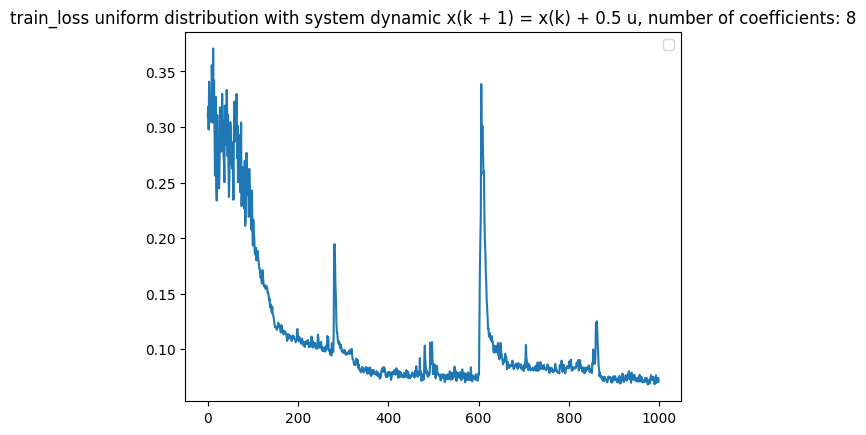

Training Complete!


In [65]:
############ Empircally we need loss < 0.01
import time
criterion.verbose = True
epochs = 1000  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
decreased = False
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, eps = 1e-4)
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty # punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
    avg_loss = running_loss / (n_samples // batch_size)
    ### He gets stuck here and often times not unstuck!
    if avg_loss < 0.011 and not decreased:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        decreased = True
    #if avg_loss < 0.009:
    #    break

    #scheduler.step(avg_loss) #### In our case test loss is the same as train loss
    print() 
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
plt.legend()
plt.show()
print("Training Complete!")

In [66]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion(x = outs, u = control)
print(criterion.c)

torch.Size([1, 8, 8])
model: tensor([[[2.9011e-01, 1.9712e-01, 2.3716e-03, 5.0097e-01, 2.7715e-01,
          6.1034e-01, 3.4264e-01, 3.4682e-01],
         [3.3339e-01, 4.3395e-03, 2.6054e-01, 6.2258e-01, 1.0132e+00,
          4.5966e-01, 2.2490e-02, 1.7728e-05],
         [4.6392e-01, 1.9965e-01, 2.4209e-01, 1.4000e-02, 2.7557e-01,
          1.0626e-01, 3.6881e-01, 4.7929e-04],
         [3.2715e-01, 6.1532e-02, 1.5144e-03, 2.7272e-01, 2.6680e-01,
          2.8139e-01, 2.5007e-01, 5.2697e-01],
         [1.0218e-02, 3.6180e-01, 1.4191e-01, 1.3338e-01, 3.7209e-01,
          2.7795e-04, 1.6151e-01, 4.6767e-01],
         [5.7923e-01, 3.6535e-03, 5.2071e-01, 2.0913e-01, 2.8616e-01,
          4.5247e-01, 1.8771e-01, 5.9943e-01],
         [2.6450e-01, 3.9544e-01, 4.7765e-01, 3.9832e-01, 4.7538e-04,
          4.5116e-01, 6.7487e-03, 4.2374e-01],
         [1.3522e-01, 2.2334e-01, 3.6040e-01, 6.1118e-01, 2.9296e-01,
          5.9530e-01, 4.4904e-01, 4.2383e-02]]], grad_fn=<CopySlices>) target: ten

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


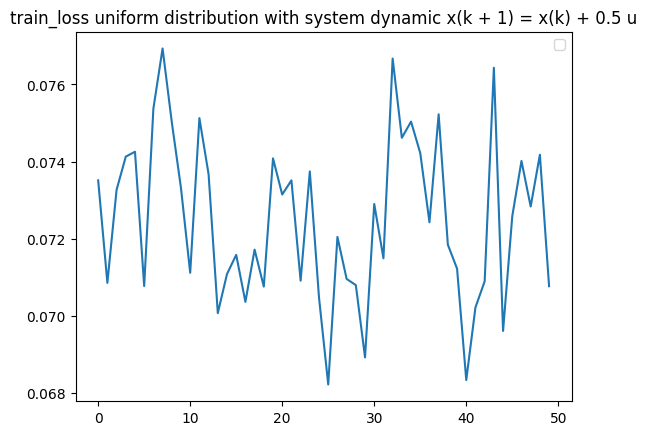

Training Complete!


In [67]:
plt.plot(train_loss[-50:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

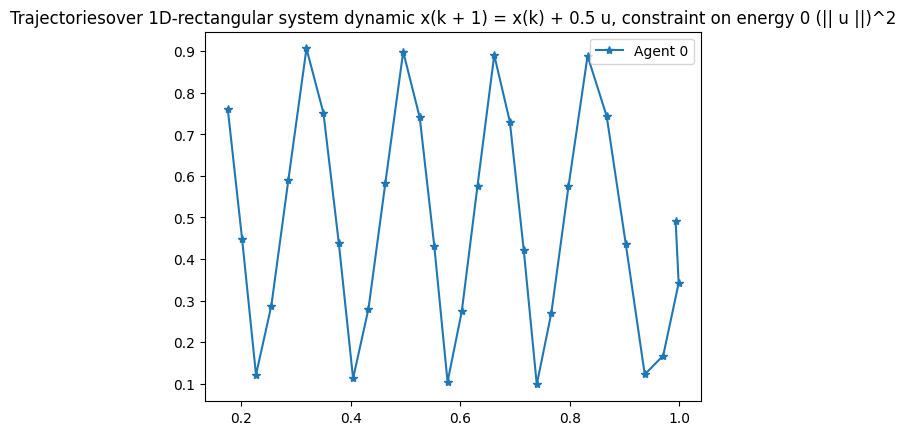

torch.Size([1, 8, 8])
model: tensor([[[2.6874e-01, 6.5735e-01, 1.0548e-01, 6.1711e-01, 4.7342e-01,
          3.5425e-01, 2.7354e-01, 5.4899e-01],
         [1.6054e-01, 2.6273e-01, 6.6079e-01, 4.7144e-01, 8.7672e-03,
          2.1666e-01, 8.5003e-01, 4.7611e-02],
         [3.3762e-01, 2.5818e-01, 3.4633e-01, 2.9562e-01, 3.7317e-01,
          4.8310e-01, 3.4907e-01, 1.5395e-02],
         [2.6504e-01, 2.4001e-01, 2.6946e-01, 4.2348e-01, 5.3562e-02,
          4.0690e-01, 5.8727e-01, 3.8786e-01],
         [2.0965e-01, 4.5589e-01, 3.4909e-01, 2.8810e-02, 5.1184e-03,
          5.0052e-01, 5.1716e-01, 4.3360e-01],
         [3.8026e-01, 2.4306e-01, 2.4737e-02, 6.4510e-01, 4.6201e-04,
          3.1979e-01, 4.7054e-02, 1.4165e-01],
         [1.6329e-02, 1.4191e-01, 2.8674e-01, 3.1660e-01, 3.5877e-01,
          3.8779e-01, 3.0486e-01, 4.7322e-01],
         [2.2590e-01, 1.7761e-04, 2.7782e-01, 5.2223e-01, 6.1654e-01,
          5.9195e-01, 6.4247e-03, 1.0239e-01]]], grad_fn=<CopySlices>) target: ten

tensor(0.0798, grad_fn=<AddBackward0>)

In [147]:
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    trajectory = outs[:,:,j,:].squeeze().detach()
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='*', linestyle='-', label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)


In [ ]:
import uuid
import os
random_id = str(uuid.uuid4())[:8]
filename = f'model_uniform_region_0-0.3.0.6-0.9_multiple_Agents{random_id}.pth'
path = os.path.join('models' , filename)
torch.save(model.state_dict(), path)
print(f"Model saved with filename: {filename}")

Model saved with filename: model_uniform_region_0-0.3.0.6-0.9_multiple_Agents94986cf4.pth


In [ ]:
ev = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32 , depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
ev.load_state_dict(torch.load(path))

<All keys matched successfully>

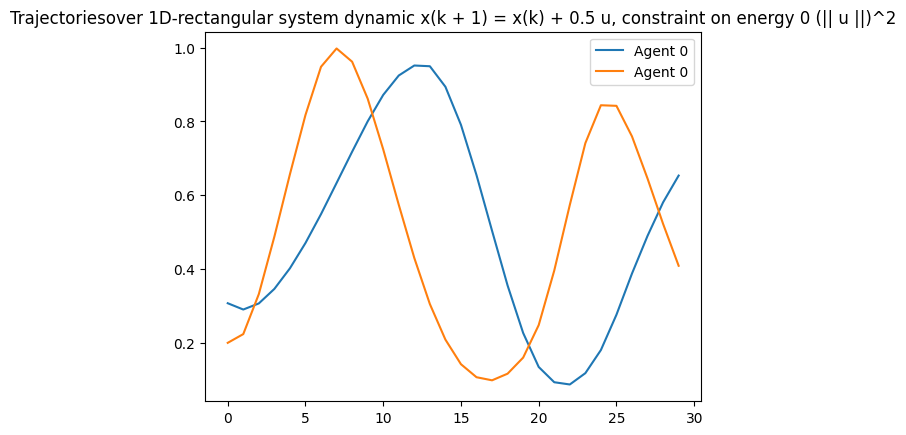

torch.Size([1, 8, 8])
model: tensor([[[0.0551, 0.0881, 0.0852, 0.0636, 0.0693, 0.0386, 0.0603, 0.1279],
         [0.0542, 0.0548, 0.0628, 0.0563, 0.1186, 0.0438, 0.0406, 0.0664],
         [0.1112, 0.0577, 0.0617, 0.0499, 0.0806, 0.0552, 0.0657, 0.0721],
         [0.0541, 0.0455, 0.0534, 0.0621, 0.0617, 0.0415, 0.0659, 0.0388],
         [0.0370, 0.0604, 0.0664, 0.0246, 0.0371, 0.0395, 0.0287, 0.0729],
         [0.0386, 0.0514, 0.0507, 0.0697, 0.0762, 0.0279, 0.0534, 0.0336],
         [0.0833, 0.0305, 0.0656, 0.0569, 0.0747, 0.0446, 0.0740, 0.0577],
         [0.0513, 0.0302, 0.0571, 0.0449, 0.0520, 0.0489, 0.0493, 0.0612]]],
       grad_fn=<CopySlices>) target: tensor([[0.0554, 0.0615, 0.0603, 0.0536, 0.0597, 0.0488, 0.0535, 0.0634],
        [0.0555, 0.0555, 0.0528, 0.0547, 0.0634, 0.0615, 0.0645, 0.0618],
        [0.0621, 0.0639, 0.0640, 0.0634, 0.0612, 0.0597, 0.0551, 0.0538],
        [0.0555, 0.0491, 0.0580, 0.0536, 0.0530, 0.0644, 0.0609, 0.0499],
        [0.0646, 0.0632, 0.0529, 0.0

tensor(0.0073, grad_fn=<AddBackward0>)

In [ ]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
ev.init_hidden(batch_size = 1)
outs, control = ev(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)